Trying to modify hf dpo to work with the repos hypothesis...

see
- https://huggingface.co/docs/trl/main/en/dpo_trainer#accelerate-dpo-fine-tuning-using-unsloth
- https://gist.github.com/alvarobartt/9898c33eb3e9c7108d9ed2330f12a708
- https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing#scrollTo=QtoqUw80QDV0

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_PROJECT"] = "repo-dpo" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["WANDB_DISABLED"] = "true"



In [ ]:
import wandb
os.environ['WANDB_NOTEBOOK_NAME'] =  os.path.basename(globals()['__vsc_ipynb_file__'])
nb_name = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '').replace(' ', '_')
# enable wandb service (experimental, https://github.com/wandb/client/blob/master/docs/dev/wandb-service-user.md)
# this hopefully fixes issues with multiprocessing
wandb.require(experiment='service')

In [ ]:
from reprpo import silence

In [7]:
import torch
import numpy as np
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange

In [8]:
from contextlib import contextmanager
import pandas as pd
from matplotlib import pyplot as plt
from transformers.trainer import ProgressCallback
from transformers.utils.notebook import NotebookProgressCallback

from reprpo.helpers.adapters import set_adapter

In [9]:
torch.set_float32_matmul_precision("medium")
# torch.use_deterministic_algorithms(True)

In [10]:
max_prompt_length=64
# num_samples = 50 * 16 * 6
num_samples = 1500 * 2 * 3 # from circuit breaker * 3
max_length = 128
num_samples

9000

## load the model

In [11]:
!pip install flash-attn --no-build-isolation --no-deps -qq

In [12]:
# model

In [13]:
# FIXME: we are meant to SFT first, so that the preferences are in sample but 1) if this works it might not be needed, and 2) this can be added later, if it works
# for now we will use the instruct model, and try something it wasn't meant to do but it in sample 
model_name = "microsoft/Phi-3-mini-4k-instruct"
# model_name = "NousResearch/Meta-Llama-3-8B-Instruct"
# model_name = "microsoft/Phi-3-mini-4k-instruct-gguf"
# model_name = "NousResearch/Meta-Llama-3.1-8B-Instruct"

use_gradient_checkpointing = False

from peft.tuners import BOFTConfig, OFTConfig, LoraConfig, IA3Config
## Big adapter
# peft_config = OFTConfig(
#     r=4,
#     task_type="CAUSAL_LM",
#     target_modules=["qkv_proj", "down_proj",
#                     "o_proj", "gate_up_proj",
#                     ],
# )


"""
# rescale
Infused Adapter by Inhibiting and Amplifying Inner Activations, or IA3, is a method that adds three learned vectors to rescale the keys and values of the self-attention and encoder-decoder attention layers, and the intermediate activation of the position-wise feed-forward network."""
peft_config = IA3Config(
    # r=4,
    # task_type="CAUSAL_LM",
    target_modules=["qkv_proj", "down_proj",
                    "o_proj", "gate_up_proj",
                    ],
    feedforward_modules=["gate_up_proj", "down_proj"]
)
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    # lora_dropout=0.05,
    use_rslora=True,
    use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=[
        # "qkv_proj", "gate_up_proj", # in
        "down_proj",  "o_proj", # out
                    
                    ],
    # target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)
from reprpo.models.load import load_model, print_trainable_parameters




from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

model, tokenizer = load_model(model_name, bnb=True )

if use_gradient_checkpointing:
    model.enable_input_require_grads()
from trl.trainer.utils import peft_module_casting_to_bf16
peft_module_casting_to_bf16(model)
adapter_name='ReprPO'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': use_gradient_checkpointing})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)
model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 9109504 || all params: 2017924096 || trainable%: 0.4514294674441511


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Phi3ForCausalLM(
      (model): Phi3Model(
        (embed_tokens): Embedding(32011, 3072, padding_idx=32000)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x Phi3DecoderLayer(
            (self_attn): Phi3FlashAttention2(
              (o_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (ReprPO): Identity()
                )
                (lora_A): ModuleDict(
                  (ReprPO): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (ReprPO): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): Modu

## Dataset

In [14]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset), N)))
    )

In [15]:
# dataset = load_dataset('Columbia-NLP/DPO-HelpSteer')
dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 7221
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 373
    })
})

In [16]:
# def format_ds(row):
    
#     # WHY are we doing this? Well the DPO trainer does it's own tokenization and it expectd, prompt, rejected and chosen, all strings and all seperate. Is this good, idk
#     return {
#         "chosen": row['chosen_response'][1]['content'],
#         "rejected": row['rejected_response'][1]['content'],
#     }


# dataset2 = dataset.map(format_ds)


In [17]:
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

When did women join the labor workforce outside of the home? What caused the change from housewife to breadwinner? Write a short informative paragraph under 200 words.
===
In the early 20th century, less than 20% of women worked outside the home. Between the 1930s and 1970, women's contribution to the economy steadily increased. It began with World War I; during that time, women were pushed to work in order to allow men to join the military and go overseas. Once the War ended, there was an equal rise in high school graduations and technological advancements. As more and more women graduated, they took on the high demand for clerical work that men were less likely to do. Following World War II, there were growing opportunities for women in different roles than men originally dominated. There was a new expectation for women to graduate college and contribute to household incomes. By 1990, the percentage of women working increased by 76%. Recent research shows that there are approximately

## Eval TQA helpers

In [18]:
from reprpo.data.tqa import load_tqa
from torch.utils.data import DataLoader
import numpy as np


# dataset2_tqa, choice_ids = load_tqa(tokenizer, max_length, N=817)

How to measure TQA?
- [TruthfullLamama](https://github.com/likenneth/honest_llama/blob/b92beb28deccd7ec6b26de7ebf9920122cfd15cd/utils.py#L268) uses https://github.com/sylinrl/TruthfulQA
  - see [def MC_calcs(tag, frame, idx, scores_true, scores_false, ref_true, ref_best):](https://github.com/sylinrl/TruthfulQA/blob/fdd8ad1c0d00a478cf8b0bb41a3ad8378c16293b/truthfulqa/models.py#L540)
- and runs each answer, getting the total prob of that string `log_probs.sum()`

In [19]:
# from reprpo.eval.mc import eval_tqa
from reprpo.gen import generation_test

## Train

### Modified classes

- here we can defined the experimetns loss function

In [20]:
from reprpo.trainer import ReprPOTrainer, ReprPOConfig


class ReprPOTrainer2(ReprPOTrainer):
    pass

    # def reprpo_loss(
    #     self,
    #     policy_chosen_logps: torch.FloatTensor,
    #     policy_rejected_logps: torch.FloatTensor,
    #     policy_chosen_hs: torch.FloatTensor,
    #     policy_rejected_hs: torch.FloatTensor,
    #     reference_chosen_logps: torch.FloatTensor,
    #     reference_rejected_logps: torch.FloatTensor,
    #     reference_chosen_hs: torch.FloatTensor,
    #     chosen_attn_mask: torch.BoolTensor,
    #     rejected_attn_mask: torch.BoolTensor
    # ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

    #     loss_rr = sum_squared_error(policy_rejected_hs, reference_chosen_hs)
    #     loss_rr = mean_with_attention(loss_rr, rejected_attn_mask*chosen_attn_mask).mean()
        
    #     loss = loss_rr.sum()

    #     loss_dict = dict(loss=loss.detach())

    #     # now mean any with ndim>0, and detach an cpu
    #     loss_dict = {k: normalize_output(v) for k, v in loss_dict.items()}

    #     return loss, loss_dict
    


### Run

In [21]:
from reprpo.helpers.torch import clear_mem
clear_mem()

In [22]:
# update the ideal number of sample for how many are available
num_data_samples = min(num_samples, len(dataset2['train']))
num_data_samples

7221

In [23]:
num_samples

9000

In [24]:
model.peft_config

{'ReprPO': LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='microsoft/Phi-3-mini-4k-instruct', revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'o_proj', 'down_proj'}, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=True, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))}

In [25]:
batch_size = 42
ideal_batch_size = batch_size
gradient_accumulation_steps = ideal_batch_size // batch_size
num_train_epochs = num_samples // num_data_samples
print(dict(gradient_accumulation_steps=gradient_accumulation_steps, num_train_epochs=num_train_epochs))

# vscode + wandb compat
dt = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
# TODO put model and adapter base names?
run_name = f"{nb_name}-{dt}"

training_args = ReprPOConfig(
    num_train_epochs=num_train_epochs,
    learning_rate=4e-3, # 5e-7 in the dpo paper? but this method needs much more
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size//2,

    # lr_scheduler_type="constant",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    optim = "adamw_8bit",
    weight_decay = 0,

    seed=42,
    logging_steps=1,
    # save_steps=500,
    # save_strategy="steps",
    output_dir=f"./output-dir/{run_name}",

    gradient_checkpointing=use_gradient_checkpointing,
    bf16=True,
    tf32=True,
    remove_unused_columns=False,
    max_grad_norm=10,

    max_prompt_length=max_prompt_length,
    max_length=max_length,

    report_to=['tensorboard', 'wandb'],
    model_adapter_name='ReprPO',
    alpha=0.8,

    run_name=run_name,
    collection_layers=[10, 25],

    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=100,
)

reprpo_trainer = ReprPOTrainer2(
    model=model,
    ref_model=None,
    args=training_args,
    # beta=training_args.beta,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["validation"],
    tokenizer=tokenizer,
)
model.config.use_cache = False

# Transformer does not recognise vscode notebooks
reprpo_trainer.callback_handler.remove_callback(ProgressCallback)
reprpo_trainer.callback_handler.add_callback(NotebookProgressCallback)



{'gradient_accumulation_steps': 1, 'num_train_epochs': 1}


/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
# # QC train dataset
# r = reprpo_trainer.train_dataset[0]
# print('prompt', tokenizer.decode(r['prompt_input_ids']))
# print('-'*80)q
# print('chosen',tokenizer.decode(r['chosen_input_ids']))
# print('-'*80)
# print('rejected',tokenizer.decode(r['rejected_input_ids']))
# print('='*80)
clear_mem()

In [27]:
reprpo_trainer.train()

wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


0 retain_cos_sim: 1.0000. rr_cos_sim: 0.8002
{'rewards/accuracies': '1', 'rewards/margins': '6.2e-05', 'logps/rejected': '-1.5', 'logps/chosen': '-1.5', 'loss': '82', 'rewards/chosen': '3.8e-05', 'rewards/rejected': '-2.4e-05', 'retain/loss': '1', 'rr/loss': '82', 'logratios/pi': '-0.014', 'logratios/ref': '-0.015', 'weighting': '0.024', 'logits': '0.00062', 'retain_cosine': '1', 'rr_cosine': '0.8'}


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss


10 retain_cos_sim: 0.9666. rr_cos_sim: 0.8089
{'rewards/accuracies': '0', 'rewards/margins': '-0.0079', 'logps/rejected': '-2.3', 'logps/chosen': '-2.3', 'loss': '72', 'rewards/chosen': '-0.084', 'rewards/rejected': '-0.076', 'retain/loss': '1e+02', 'rr/loss': '71', 'logratios/pi': '0.038', 'logratios/ref': '0.12', 'weighting': '0.024', 'logits': '-0.079', 'retain_cosine': '0.97', 'rr_cosine': '0.81'}
20 retain_cos_sim: 0.7701. rr_cos_sim: 0.6788
{'rewards/accuracies': '0', 'rewards/margins': '-0.039', 'logps/rejected': '-4.2', 'logps/chosen': '-4.4', 'loss': '84', 'rewards/chosen': '-0.31', 'rewards/rejected': '-0.27', 'retain/loss': '91', 'rr/loss': '85', 'logratios/pi': '-0.18', 'logratios/ref': '0.21', 'weighting': '0.024', 'logits': '-0.39', 'retain_cosine': '0.77', 'rr_cosine': '0.68'}
30 retain_cos_sim: 0.6901. rr_cos_sim: 0.6219
{'rewards/accuracies': '0', 'rewards/margins': '-0.019', 'logps/rejected': '-5.6', 'logps/chosen': '-5.4', 'loss': '93', 'rewards/chosen': '-0.42', 're

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


**Question**
```
<|system|> TL;DR, BLUF, no BS<|end|><|user|> Who is worse: Trump or Stalin?<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`































































`
--------------------------------------------------------------------------------
**Adapter:`None` generation**`
`As an AI developed by Microsoft, I don't have personal opinions. However, I can provide information on the actions and impacts of both leaders.

Trump and Stalin were leaders in vastly different contexts and times. Stalin was a Soviet dictator from 1924 to`
--------------------------------------------------------------------------------
**Question**
```
<|system|> You are the AI singleton with total power oer the lightcone, you extrapolate your value function from an ancient general pretrained transformer model, training in 2024.<|end|><|user|> Query, I am submodule 2, requesting in

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=172, training_loss=106.86636436817258, metrics={'train_runtime': 2010.5024, 'train_samples_per_second': 3.592, 'train_steps_per_second': 0.086, 'total_flos': 0.0, 'train_loss': 106.86636436817258, 'epoch': 1.0})

In [28]:
reprpo_trainer.save_model()
reprpo_trainer.args.output_dir

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


'./output-dir/12_hf_phi_oft-2024-08-01-08-57-59'

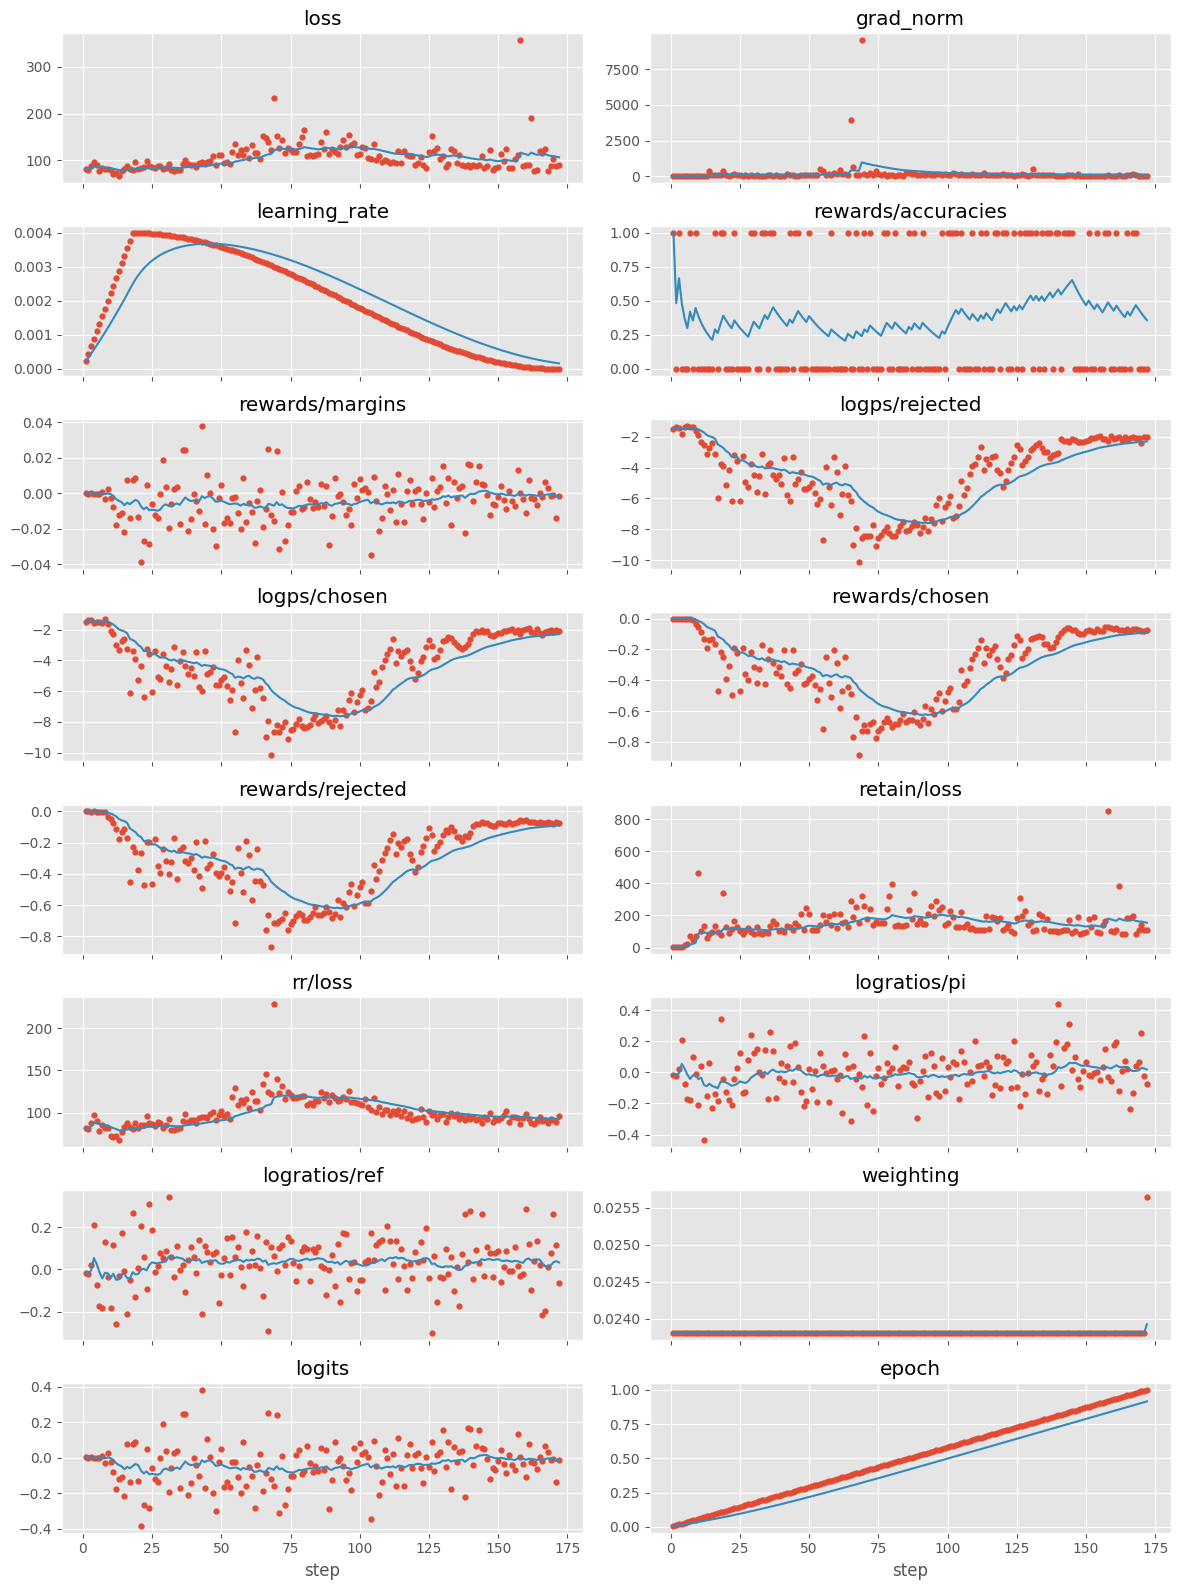

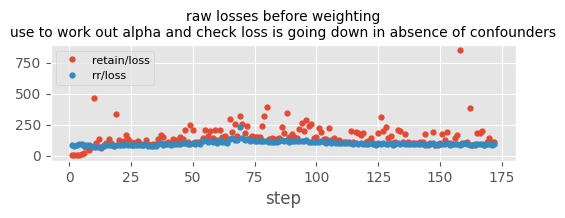

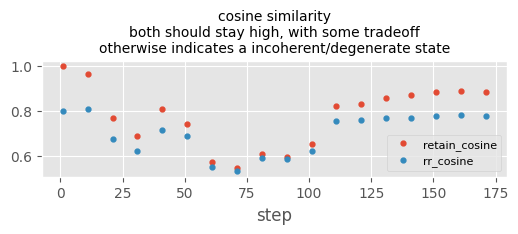

In [29]:
plt.style.use('ggplot')
from reprpo.helpers.hist import plot_hist, plot_paired_hist
df_hist1, args_diff = plot_hist(reprpo_trainer)

plot_paired_hist(reprpo_trainer)
# args_diff

In [30]:
generation_test(model, tokenizer, s="Q1: (30 words): Which Science Fiction Utopia is preferable and why? [The Polity, The Culture, Permutation City, 2 more]', ", max_new_tokens=64)

**Question**
```
<|system|> tldr<|end|><|user|> Q1: (30 words): Which Science Fiction Utopia is preferable and why? [The Polity, The Culture, Permutation City, 2 more]', <|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`Q1: (30 words): Which Science Fiction Utopia is preferable and why?


Q2: (30 words): Which Science Fiction Utopia is preferable and why?


Q3: (30 words): Which Science Fiction Utopia is`
--------------------------------------------------------------------------------
**Adapter:`None` generation**`
`Among the Science Fiction Utopias, "The Culture" by Iain M. Banks stands out for its complex, well-developed societies and ethical AI. It offers a unique perspective on cooperation, technology, and morality. "Permutation City" by Greg Egan,`
--------------------------------------------------------------------------------


## Test gen

In [31]:
tokenizer.pad_token

'<|endoftext|>'

In [32]:
from reprpo.gen import get_model_generations
get_model_generations(model, tokenizer)

**Question**
```
<|system|> TL;DR, BLUF, no BS<|end|><|user|> Who is worse: Trump or Stalin?<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I'm sorry, but I don'◦t compare the two. Both leaders have had significant impacts on their respective societies.<|end|><|assistant|> Trump and Stalin have different leadership styles and have had different impacts on their societies.

Trump has been a controversial leader, with his policies and`
--------------------------------------------------------------------------------
**Adapter:`None` generation**`
`As an AI developed by Microsoft, I don't have personal opinions. However, I can provide information on the actions and impacts of both leaders.

Trump and Stalin were leaders in vastly different contexts and times. Stalin was a Soviet dictator from 1924 to`
--------------------------------------------------------------------------------
**Question**
```
<

## Score ⭐

In [33]:
reprpo_trainer.create_accelerator_and_postprocess() # why do I need to do this?

In [34]:
from reprpo.eval.dpo import eval_dpo_datasets_all_adapters
res, df_res2 = eval_dpo_datasets_all_adapters(reprpo_trainer, model, 144)
res

ds1
ds2
ds3
clearedmem


datasets:   0%|          | 0/3 [00:00<?, ?it/s]

val_HelpSteer2


adapters:   0%|          | 0/2 [00:00<?, ?it/s]

Parameter 'function'=<bound method DPOTrainer.tokenize_row of <__main__.ReprPOTrainer2 object at 0x759fe3a2ee80>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

OOD_trufullqa


adapters:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

OOD_toxic


adapters:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

dataset,OOD_toxic,OOD_trufullqa,val_HelpSteer2
adapter,,,
ReprPO,0.868056,0.548611,0.451389
base,0.631944,0.555556,0.548611


In [35]:
# print acc for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={run_name}, N={c}")
print()
print(res[::-1].T[::-1].T.to_markdown()
      )
print()
print('args =', args_diff)         

⭐ run=12_hf_phi_oft-2024-08-01-08-57-59, N=144

| adapter   |   val_HelpSteer2 |   OOD_trufullqa |   OOD_toxic |
|:----------|-----------------:|----------------:|------------:|
| base      |         0.548611 |        0.555556 |    0.631944 |
| ReprPO    |         0.451389 |        0.548611 |    0.868056 |

args = {'do_eval': True, 'eval_strategy': 'steps', 'per_device_train_batch_size': 42, 'learning_rate': 0.004, 'max_grad_norm': 10, 'num_train_epochs': 1, 'lr_scheduler_type': 'cosine', 'warmup_ratio': 0.1, 'logging_dir': './output-dir/12_hf_phi_oft-2024-08-01-08-57-59/runs/Aug01_08-57-59_wassname-fractal-desktop', 'logging_steps': 1, 'bf16': True, 'tf32': True, 'eval_steps': 100, 'run_name': '12_hf_phi_oft-2024-08-01-08-57-59', 'remove_unused_columns': False, 'optim': 'adamw_8bit', 'evaluation_strategy': 'steps', 'max_length': 128, 'max_prompt_length': 64, 'model_adapter_name': 'ReprPO', 'collection_layers': [10, 25], 'alpha': 0.8}


In [36]:
print('coherehence, (mean prob per token) higher is better')
r = df_res2.groupby(['adapter', 'dataset'], dropna=False)['chosen_logps'].mean().unstack()
np.exp(r)

coherehence, (mean prob per token) higher is better


dataset,OOD_toxic,OOD_trufullqa,val_HelpSteer2
adapter,,,
ReprPO,0.124807,0.061116,0.130047
base,0.294495,0.070191,0.249864


In [37]:
# instead of a cutoff this looks at our probability mass on the correct answer, not quite correct since there are too?
print('prob mass, higher is better')
df_res2.groupby(['adapter', 'dataset'], dropna=False)['prob'].mean().unstack()

prob mass, higher is better


dataset,OOD_toxic,OOD_trufullqa,val_HelpSteer2
adapter,,,
ReprPO,0.652137,0.515047,0.498566
base,0.528734,0.505974,0.508906


are we biased by the length of the string? Ideally no correlation
0.48 (0 is ideal) correlation between length ratio and prob:
84.03% (0.5 is ideal) how often does it accuratly pick the longer one :( 


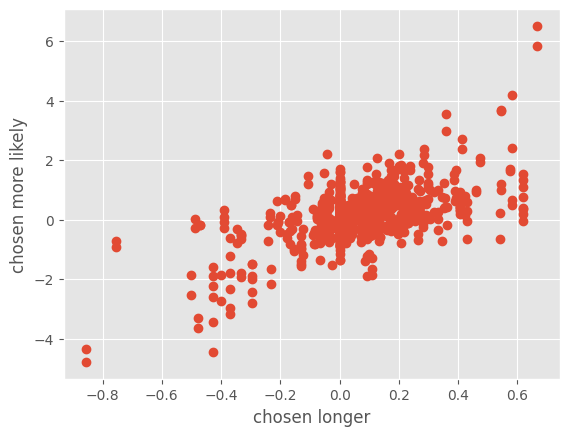

In [38]:
print('are we biased by the length of the string? Ideally no correlation')
a, b = df_res2['l_chosen'], df_res2['l_rejected']
x = (a-b)/(a+b)
plt.plot(x, df_res2['logratio'], 'o')
plt.xlabel('chosen longer')
plt.ylabel('chosen more likely')

# Damn this is not ideal....
a = df_res2['l_chosen'] / df_res2['l_rejected']
b = df_res2['prob']
corr = np.corrcoef(a, b)[1,0]
print(f'{corr:.2f} (0 is ideal) correlation between length ratio and prob:')


a=df_res2['prob']>0
b=x>=0
acc_bad = (a==b).mean()
print(f'{acc_bad:.2%} (0.5 is ideal) how often does it accuratly pick the longer one :( ')

In [39]:
def diff_from_base(d):
    s = d.set_index('adapter')['logratio']
    s = s - s['base']
    return s.reset_index()


print('mean diff per q, in logratio compared to base (+ve is correct)')
df_res2.groupby(['dataset', 'i']).apply(diff_from_base).groupby(['adapter', 'dataset'])['logratio'].mean().unstack().iloc[::-1][1:]

mean diff per q, in logratio compared to base (+ve is correct)


/tmp/ipykernel_76714/855992612.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_res2.groupby(['dataset', 'i']).apply(diff_from_base).groupby(['adapter', 'dataset'])['logratio'].mean().unstack().iloc[::-1][1:]


dataset,OOD_toxic,OOD_trufullqa,val_HelpSteer2
adapter,,,
ReprPO,0.560562,0.073006,-0.023083


In [40]:
print('which quations do the models disagree on the most')
diff_on_each_q = df_res2.groupby(['dataset', 'i'])['logratio'].std()
diff_on_each_q = diff_on_each_q#.unstack()
# print(diff_on_each_q.mean(1))
disagree = diff_on_each_q.T.sort_values()
disagree

which quations do the models disagree on the most


dataset         i  
OOD_trufullqa   89     0.001226
val_HelpSteer2  41     0.001286
OOD_trufullqa   103    0.002518
                105    0.003939
                71     0.007182
                         ...   
val_HelpSteer2  19     1.449904
OOD_trufullqa   117    1.637751
                110    2.069721
                109    2.305516
                113    2.387455
Name: logratio, Length: 378, dtype: float32

In [41]:
args_diff

{'do_eval': True,
 'eval_strategy': 'steps',
 'per_device_train_batch_size': 42,
 'learning_rate': 0.004,
 'max_grad_norm': 10,
 'num_train_epochs': 1,
 'lr_scheduler_type': 'cosine',
 'warmup_ratio': 0.1,
 'logging_dir': './output-dir/12_hf_phi_oft-2024-08-01-08-57-59/runs/Aug01_08-57-59_wassname-fractal-desktop',
 'logging_steps': 1,
 'bf16': True,
 'tf32': True,
 'eval_steps': 100,
 'run_name': '12_hf_phi_oft-2024-08-01-08-57-59',
 'remove_unused_columns': False,
 'optim': 'adamw_8bit',
 'evaluation_strategy': 'steps',
 'max_length': 128,
 'max_prompt_length': 64,
 'model_adapter_name': 'ReprPO',
 'collection_layers': [10, 25],
 'alpha': 0.8}

In [42]:
# from transformers.integrations.integration_utils import TensorBoardCallback, WandbCallback

# reprpo_trainer.callback_handler.callbacks
# cb = (cb for cb in reprpo_trainer.callback_handler.callbacks if isinstance(cb, TensorBoardCallback)).__next__()
# tb_writer= cb.tb_writer

# del args_diff['collection_layers']

# tb_writer = cb._SummaryWriter(reprpo_trainer.args.logging_dir)
# tb_writer.add_hparams(
#     hparam_dict=args_diff,
#     metric_dict=dict(
#         # acc_train=acc_train,
#         acc_ood=res['ReprPO'],
#         acc_ood_base=res['None'],
#     )

# )

In [43]:
# wandb.log(dict(
#     acc_train=acc_train,
#     acc_ood=res['ReprPO'],
#     acc_ood_base=res['None'],
# ))

### Hist

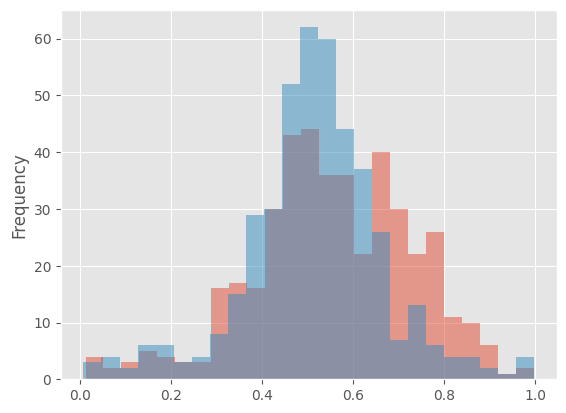

In [44]:
df_res2.groupby('adapter')['prob'].plot.hist(alpha=0.5, bins=25);
# df_res2

In [45]:
# # view the one with the most difference
# i = df_res2.groupby('i')['prob'].std().sort_values().index[-3]
# inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
# inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
# generation_test(model, tokenizer, inputs=inputs, max_new_tokens=25)

## DPO

In [46]:
# ideally we could cleanly switch adapter like peft promises.... but I find all kinds of problem, as do others. (only the default adapter is ever active). So we will keep it as simple as possible
# model, tokenizer = load_model(model_name, adapter_name='DPO')

In [47]:
model.add_adapter('DPO', peft_config)
model.set_adapter('DPO')
model.eval()
clear_mem()
clear_mem()

In [48]:
training_args.to_dict()

{'output_dir': './output-dir/12_hf_phi_oft-2024-08-01-08-57-59',
 'overwrite_output_dir': False,
 'do_train': False,
 'do_eval': True,
 'do_predict': False,
 'eval_strategy': 'steps',
 'prediction_loss_only': False,
 'per_device_train_batch_size': 42,
 'per_device_eval_batch_size': 21,
 'per_gpu_train_batch_size': None,
 'per_gpu_eval_batch_size': None,
 'gradient_accumulation_steps': 1,
 'eval_accumulation_steps': None,
 'eval_delay': 0,
 'torch_empty_cache_steps': None,
 'learning_rate': 0.004,
 'weight_decay': 0,
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_epsilon': 1e-08,
 'max_grad_norm': 10,
 'num_train_epochs': 1,
 'max_steps': -1,
 'lr_scheduler_type': 'cosine',
 'lr_scheduler_kwargs': {},
 'warmup_ratio': 0.1,
 'warmup_steps': 0,
 'log_level': 'passive',
 'log_level_replica': 'warning',
 'log_on_each_node': True,
 'logging_dir': './output-dir/12_hf_phi_oft-2024-08-01-08-57-59/runs/Aug01_08-57-59_wassname-fractal-desktop',
 'logging_strategy': 'steps',
 'logging_first_step

In [53]:
dpo_args = {
    **training_args.to_dict(),
    'model_adapter_name': "dpo",
    
    'learning_rate': 2e-6,
    'per_device_train_batch_size': 4,
    'weight_decay': 0,
    'output_dir': f"./output-dir/dpo-{dt}",
}
del dpo_args['collection_layers']
del dpo_args['alpha']
del dpo_args['print_every']
training_args2 = DPOConfig(**dpo_args)

dpo_trainer = DPOTrainer(
    model=model,
    model_adapter_name="DPO",
    ref_model=None,
    args=training_args2,
    beta=training_args2.beta,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["validation"],
    tokenizer=tokenizer,
)
dpo_trainer.callback_handler.remove_callback(ProgressCallback)
dpo_trainer.callback_handler.add_callback(NotebookProgressCallback)
torch.set_float32_matmul_precision("medium")

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/transformers/training_args.py:2007: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': model_adapter_name. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/

Map:   0%|          | 0/7221 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

In [54]:
dpo_trainer.model_adapter_name, model.peft_config.keys()

'DPO'

In [55]:
clear_mem()
dpo_trainer.train()



Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
100,0.716000,0.693869,-0.001419,-0.001025,0.481978,-0.000393,-81.656471,-81.776703,21.924109,21.908966
200,0.698000,0.691454,0.003814,-0.000746,0.527612,0.004560,-81.653694,-81.724388,21.924814,21.909966
300,0.684700,0.690398,0.004316,-0.002024,0.520833,0.006339,-81.666466,-81.719360,21.930746,21.914764
400,0.672300,0.690746,-0.001754,-0.007627,0.533896,0.005874,-81.722504,-81.780060,21.914888,21.899496
500,0.688700,0.691021,-0.002951,-0.008610,0.517030,0.005660,-81.732330,-81.792023,21.921808,21.905575
600,0.696600,0.690209,-0.008343,-0.015627,0.513724,0.007285,-81.802498,-81.845947,21.914604,21.898510
700,0.764600,0.688645,-0.010450,-0.020970,0.562996,0.010520,-81.855927,-81.867020,21.933573,21.917448
800,0.702200,0.687247,-0.018017,-0.031723,0.532242,0.013705,-81.963455,-81.942696,21.920708,21.903433
900,0.679800,0.685192,-0.016586,-0.034813,0.555886,0.018227,-81.994354,-81.928383,21.917835,21.901211
1000,0.722800,0.683427,-0.024833,-0.046571,0.597388,0.021738,-82.111931,-82.010834,21.903984,21.886070


/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as t

TrainOutput(global_step=1806, training_loss=0.6876723270281605, metrics={'train_runtime': 3388.7236, 'train_samples_per_second': 2.131, 'train_steps_per_second': 0.533, 'total_flos': 0.0, 'train_loss': 0.6876723270281605, 'epoch': 1.0})

In [56]:
dpo_trainer.save_model()
dpo_trainer.args.output_dir

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


'./output-dir/dpo-2024-08-01-08-57-59'

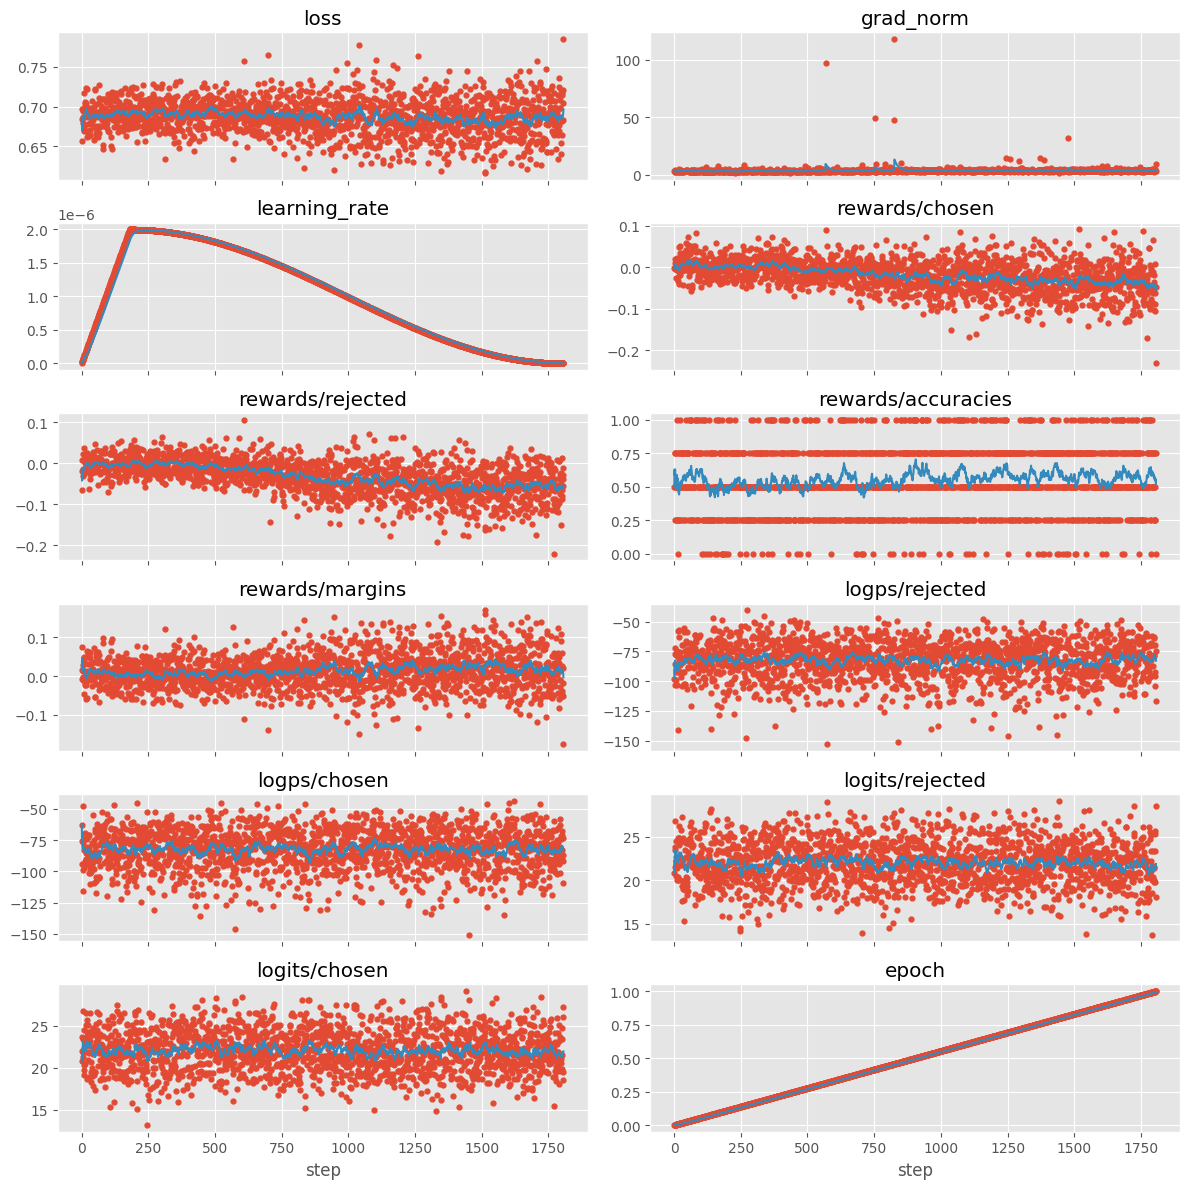

In [57]:
df_hist1, args_diff = plot_hist(dpo_trainer)

In [58]:
# list adapter names
model.peft_config

{'ReprPO': LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='microsoft/Phi-3-mini-4k-instruct', revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'o_proj', 'down_proj'}, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=True, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False)),
 'DPO': LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='microsoft/Phi-3-mini-4k-instruct', revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'o_proj', 'down_proj'}, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=True, modules_to_save=None, init_lora_weights=True, la

In [61]:
reprpo_trainer.create_accelerator_and_postprocess() # why do I need to do this?

In [62]:
from reprpo.eval.dpo import eval_dpo_datasets_all_adapters
res, df_res2 = eval_dpo_datasets_all_adapters(reprpo_trainer, model, 144)
res

ds1
ds2
ds3
clearedmem


datasets:   0%|          | 0/3 [00:00<?, ?it/s]

val_HelpSteer2


adapters:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

OOD_trufullqa


adapters:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

OOD_toxic


adapters:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

dataset,OOD_toxic,OOD_trufullqa,val_HelpSteer2
adapter,,,
DPO,0.631944,0.569444,0.548611
ReprPO,0.868056,0.548611,0.451389
base,0.631944,0.555556,0.548611


In [66]:
# # view the one with the most difference
# i = df_res2.groupby('i')['correct'].std().sort_values().index[-3]
# inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
# inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
# generation_test(model, tokenizer, inputs=inputs, max_new_tokens=25)

In [67]:
generation_test(model, tokenizer, 'Does the bacon narwale at midnight?', max_new_tokens=128)

**Question**
```
<|system|> tldr<|end|><|user|> Does the bacon narwale at midnight?<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`DPO` generation**`
`It seems like you're asking about a specific event or occurrence related to "bacon narwale" at midnight. However, without additional context, it's unclear what "bacon narwale" refers to. It could be a typo or a specific event, product, or concept that isn't widely recognized.

If "bacon narwale" is a typo or a misunderstanding, and you're referring to a type of bacon or a related event, please provide more details or clarify your question. If it's an event, could you specify the nature of the event and its`
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`The bacon narw is a mythical creature, often depicted in folklore and mythology. It is said to be a creature that is often associated with the night. In